importing libraries and reading the data:

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
import re

In [2]:
datafile = "Datasets and Resources-20230319/matala2_cosmetics_2019-Nov.csv" 

In [3]:
data = pd.read_csv(datafile)

<ipython-input-3-307c2792c910>:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(datafile)


### 1st question
create new column containing the duration until the next event on the same session:

In [4]:
#first understanding our data type-
data['event_time']=data.event_time.str.removesuffix(' UTC')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4635837 entries, 0 to 4635836
Data columns (total 9 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   event_time     object
 1   event_type     object
 2   product_id     int64 
 3   category_id    int64 
 4   category_code  object
 5   brand          object
 6   price          object
 7   user_id        int64 
 8   user_session   object
dtypes: int64(3), object(6)
memory usage: 318.3+ MB


In [25]:
#changing the event_time column to be of type "datetime"
data['event_time']=pd.to_datetime(data['event_time'])
data['event_time']

437209    2019-11-04 15:28:57
2483241   2019-11-19 09:56:09
2494623   2019-11-19 11:14:48
2640971   2019-11-20 11:58:06
2641003   2019-11-20 11:58:27
                  ...        
4635733   2019-11-30 23:56:14
4635736   2019-11-30 23:56:17
4635737   2019-11-30 23:56:21
4635752   2019-11-30 23:56:46
4635836   2019-11-30 23:59:58
Name: event_time, Length: 4635837, dtype: datetime64[ns]

In [6]:
#finally, creating the column 'duration_to_next_event' and showing the data-
data=data.sort_values(by=['user_id','event_time','user_session'])
data['duration']=abs(data.groupby(['user_id','user_session'])['event_time'].diff()).fillna(pd.Timedelta(seconds=0))
data['duration_to_next_event']=data['duration'].dt.total_seconds()
data.tail(6)


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,duration,duration_to_next_event
4635724,2019-11-30 23:56:00,view,5886282,1487580013950664926,NaN,NaN,21.59,579968623,a06e9a89-55ff-4c3a-abd6-aa4fdf808058,0 days 00:00:17,17.0
4635733,2019-11-30 23:56:14,view,5892179,1487580013950664926,NaN,NaN,18.89,579968623,a06e9a89-55ff-4c3a-abd6-aa4fdf808058,0 days 00:00:14,14.0
4635736,2019-11-30 23:56:17,view,5900651,1487580013950664926,NaN,NaN,19.52,579968623,a06e9a89-55ff-4c3a-abd6-aa4fdf808058,0 days 00:00:03,3.0
4635737,2019-11-30 23:56:21,view,5892179,1487580013950664926,NaN,NaN,18.89,579968623,a06e9a89-55ff-4c3a-abd6-aa4fdf808058,0 days 00:00:04,4.0
4635752,2019-11-30 23:56:46,view,5790563,1487580008263189483,NaN,NaN,7.14,579968937,878af093-7570-48ae-966c-d50ce61e390c,0 days 00:00:00,0.0
4635836,2019-11-30 23:59:58,view,5880201,2029731308699124089,NaN,rasyan,3.76,579969854,e9fa2c3e-8c9e-448c-880a-21ca57c18b3b,0 days 00:00:00,0.0


#### 2nd question

In [24]:
data['funnel_number']= (data['duration']>pd.Timedelta(days=5)).groupby(data['user_id']).cumsum()+1
#data[data['user_id']==20554973]- found a problematic value , spoke with Anat regarding this user




,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,duration,duration_to_next_event,funnel_number,index_in_funnel
1910391,2019-11-14 19:55:54,view,5884356,1487580010561667147,NaN,oniq,10.32,560528468,70877df8-fb1d-4f66-a8fd-4114fb11cecb,0 days 00:00:00,0.0,1,1
1910532,2019-11-14 19:57:26,view,5745356,1487580010360340546,NaN,NaN,8.25,560528468,70877df8-fb1d-4f66-a8fd-4114fb11cecb,0 days 00:01:32,92.0,1,1
1910720,2019-11-14 19:59:12,view,16690,1487580013950664926,NaN,enas,9.98,560528468,70877df8-fb1d-4f66-a8fd-4114fb11cecb,0 days 00:01:46,106.0,1,1
1910767,2019-11-14 19:59:27,view,5714240,1487580006434472855,NaN,jas,123.81,560528468,70877df8-fb1d-4f66-a8fd-4114fb11cecb,0 days 00:00:15,15.0,1,1


#### 3rd question

In [8]:
data['index_in_funnel'] = data.groupby(['funnel_number']).ngroup()+1


#### 4th question

In [9]:
#first, we make sure the column is of str type so the RegEx will be more accurate (without it I received Null values) 
data['price']=data['price'].astype(str)
#using RegEx to show only numbers
data['price'] = data['price'].apply(lambda x: ' '.join(re.findall(r'\d+\.\d+|\d+', x)))
#changing the column type to FLOAT
data['price']=data['price'].astype(float)

#### 5th question

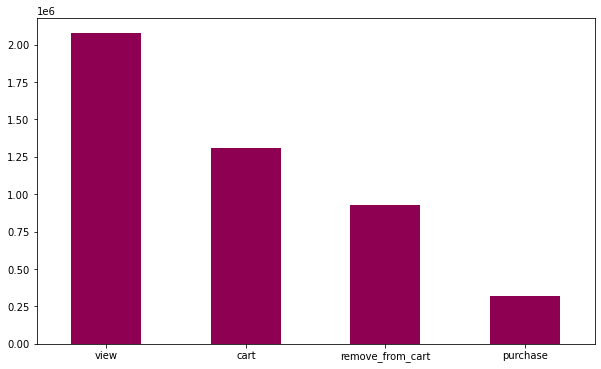

In [10]:
data.event_type.value_counts().plot(kind='bar',figsize=(10, 6), rot=0,colormap='PiYG');

#### 6th question
creating new columns:

In [11]:
#total number of events per session. aggregated with funnel as well to make sure they will show coherently on my dataframe
session_data = data.groupby(['user_id','user_session','funnel_number','index_in_funnel']).agg(
    num_of_events=('user_session' , lambda x: x.count())
).reset_index()
session_data


,user_id,user_session,funnel_number,index_in_funnel,num_of_events
0,1120748,d0484d94-7ac1-44e8-a310-2360da11ad9d,1,1,1
1,1458813,6873a205-d9f5-4d51-b3eb-b4bfddfe907c,1,1,1
2,1458813,921ff98c-a419-4132-af94-ee26880334b0,1,1,28
3,1458813,ad1a2e9e-cc14-4b98-b70b-5dd539e76bba,1,1,1
4,1458813,b16644a2-44db-4650-8156-f6f03782d432,1,1,1
...,...,...,...,...,...
943787,579967088,670cb8b4-bef1-4ec7-bfe8-7c8317967c74,1,1,1
943788,579968012,547ad51a-cdf2-4a0a-b819-8061c012bcee,1,1,1
943789,579968623,a06e9a89-55ff-4c3a-abd6-aa4fdf808058,1,1,5
943790,579968937,878af093-7570-48ae-966c-d50ce61e390c,1,1,1


In [12]:
#total session duration:
session_duration = data.groupby(['user_id','user_session','funnel_number','index_in_funnel'])['duration'].sum()
session_duration=session_duration.reset_index()
#session_duration[session_duration['user_id']==20554973] an example of the user who has different days 

,user_id,user_session,funnel_number,index_in_funnel,duration
64,20554973,e6f2e7c1-1060-4e8f-87eb-80c85cf2fd48,1,1,0 days 00:02:07
65,20554973,e6f2e7c1-1060-4e8f-87eb-80c85cf2fd48,2,2,13 days 00:09:02
66,20554973,e6f2e7c1-1060-4e8f-87eb-80c85cf2fd48,3,3,11 days 08:24:09


In [13]:
#merge the session duration to the new DF
session_data = pd.merge(session_data, session_duration[['duration','user_session']], on='user_session', how='outer')
session_data

,user_id,user_session,funnel_number,index_in_funnel,num_of_events,duration
0,1120748,d0484d94-7ac1-44e8-a310-2360da11ad9d,1,1,1,0 days 00:00:00
1,1458813,6873a205-d9f5-4d51-b3eb-b4bfddfe907c,1,1,1,0 days 00:00:00
2,1458813,921ff98c-a419-4132-af94-ee26880334b0,1,1,28,0 days 01:03:09
3,1458813,ad1a2e9e-cc14-4b98-b70b-5dd539e76bba,1,1,1,0 days 00:00:00
4,1458813,b16644a2-44db-4650-8156-f6f03782d432,1,1,1,0 days 00:00:00
...,...,...,...,...,...,...
947987,579967088,670cb8b4-bef1-4ec7-bfe8-7c8317967c74,1,1,1,0 days 00:00:00
947988,579968012,547ad51a-cdf2-4a0a-b819-8061c012bcee,1,1,1,0 days 00:00:00
947989,579968623,a06e9a89-55ff-4c3a-abd6-aa4fdf808058,1,1,5,0 days 00:00:38
947990,579968937,878af093-7570-48ae-966c-d50ce61e390c,1,1,1,0 days 00:00:00


In [14]:
#new DF for listing all users who viewd items
session_data_view= data[data['event_type'] =='view']
session_data_view = session_data_view.groupby(['user_id','user_session','funnel_number','index_in_funnel']).agg(
   list_of_viewed=( 'product_id',lambda x: list(x))).reset_index()
session_data_view

,user_id,user_session,funnel_number,index_in_funnel,list_of_viewed
0,1120748,d0484d94-7ac1-44e8-a310-2360da11ad9d,1,1,[5240]
1,1458813,6873a205-d9f5-4d51-b3eb-b4bfddfe907c,1,1,[5814066]
2,1458813,921ff98c-a419-4132-af94-ee26880334b0,1,1,"[5800358, 5800349, 5800349, 5800358, 5712576, ..."
3,1458813,ad1a2e9e-cc14-4b98-b70b-5dd539e76bba,1,1,[5711087]
4,1458813,b16644a2-44db-4650-8156-f6f03782d432,1,1,[5711145]
...,...,...,...,...,...
885053,579967088,670cb8b4-bef1-4ec7-bfe8-7c8317967c74,1,1,[5881428]
885054,579968012,547ad51a-cdf2-4a0a-b819-8061c012bcee,1,1,[5873630]
885055,579968623,a06e9a89-55ff-4c3a-abd6-aa4fdf808058,1,1,"[5892179, 5886282, 5892179, 5900651, 5892179]"
885056,579968937,878af093-7570-48ae-966c-d50ce61e390c,1,1,[5790563]


In [15]:
#new DF for listing all users who added items to cart
session_data_cart= data[data['event_type'] =='cart']
session_data_cart = session_data_cart.groupby(['user_id','user_session','funnel_number','index_in_funnel']).agg(
   list_of_added_to_cart =( 'product_id',lambda x: list(x))).reset_index()
session_data_cart

,user_id,user_session,funnel_number,index_in_funnel,list_of_added_to_cart
0,5493470,dad8b91c-b700-4be1-9f14-e80af656d441,1,1,"[5745712, 49674, 5587748, 4590, 34763]"
1,6217356,a6a9d797-11fd-451a-992b-a6dae80be0a4,1,1,[5569506]
2,9794320,0757ddda-e4a6-45d3-b577-cc94a5fe1d5f,1,1,"[5896421, 5841190, 5896422, 5896419]"
3,9794320,09894a4f-860e-448c-83d5-691590d28617,1,1,"[5896421, 5896422]"
4,9794320,1caa56ab-bd6f-4e0f-957a-30d19ba4f4c0,1,1,"[5811668, 5811668, 5724608, 5724658, 5724658, ..."
...,...,...,...,...,...
213415,579959455,17e5dca7-b1a1-4242-a96e-430921192db0,1,1,[4905]
213416,579959992,8e734f2b-32cf-45d6-b074-90cbfe6f14e5,1,1,[5528035]
213417,579962565,bef50da6-0084-4579-8477-70f00588c334,1,1,[5820072]
213418,579962710,06231298-55bb-4d9c-895f-7e90677fbee7,1,1,"[5809910, 5809912, 5816172, 5816169, 5813066, ..."


In [16]:
#new DF for listing all users who purchased items
session_data_purchase= data[data['event_type'] =='purchase']
session_data_purchase = session_data_purchase.groupby(['user_id','user_session','funnel_number','index_in_funnel']).agg(
   list_of_purchased =( 'product_id',lambda x: list(x))).reset_index()
session_data_purchase

,user_id,user_session,funnel_number,index_in_funnel,list_of_purchased
0,9794320,30d70cc3-86ee-4b5d-879c-40f06132163c,1,1,"[5812033, 5724621, 5809910, 5811668]"
1,10079204,f873d16b-4efa-4e92-81be-92948aef2ff5,1,1,"[5766379, 5614842]"
2,10280338,bcc9bfa0-8a71-485d-b315-297b0038b4c2,1,1,"[5809910, 5809911, 5809912, 5862544, 5870648, ..."
3,10280338,bce6164d-93ef-4d65-ae2f-7ee15552eae7,1,1,"[5850620, 5850625, 5850621, 5850619, 5816166, ..."
4,15781728,81b05dd4-d5a5-4a80-b103-a29d0b5ed96e,1,1,"[5846442, 5686083]"
...,...,...,...,...,...
36636,579906406,46fe6cbc-8fbc-44c5-8543-6291b648faa5,1,1,"[5809911, 5809910]"
36637,579916096,aa3e2b8c-06f8-4dce-8b74-1546ecd08d31,1,1,"[5770054, 5770013, 5769890, 5808333]"
36638,579924768,65fd6e84-3ca0-44aa-8f64-a519041de4ec,1,1,"[5649270, 5335, 5802678]"
36639,579925377,129dfa88-8785-4342-9666-eca5683020e3,1,1,"[5759491, 5810673, 5837126, 5813882, 5612762, ..."


In [17]:
#aggergating it all to the new DF
session_data = pd.merge(session_data, session_data_view[['user_session','list_of_viewed']], on='user_session', how='outer')
session_data = pd.merge(session_data, session_data_cart[['user_session','list_of_added_to_cart']], on='user_session', how='outer')
session_data = pd.merge(session_data, session_data_purchase[['user_session','list_of_purchased']], on='user_session', how='outer')
session_data

,user_id,user_session,funnel_number,index_in_funnel,num_of_events,duration,list_of_viewed,list_of_added_to_cart,list_of_purchased
0,1120748,d0484d94-7ac1-44e8-a310-2360da11ad9d,1,1,1,0 days 00:00:00,[5240],NaN,NaN
1,1458813,6873a205-d9f5-4d51-b3eb-b4bfddfe907c,1,1,1,0 days 00:00:00,[5814066],NaN,NaN
2,1458813,921ff98c-a419-4132-af94-ee26880334b0,1,1,28,0 days 01:03:09,"[5800358, 5800349, 5800349, 5800358, 5712576, ...",NaN,NaN
3,1458813,ad1a2e9e-cc14-4b98-b70b-5dd539e76bba,1,1,1,0 days 00:00:00,[5711087],NaN,NaN
4,1458813,b16644a2-44db-4650-8156-f6f03782d432,1,1,1,0 days 00:00:00,[5711145],NaN,NaN
...,...,...,...,...,...,...,...,...,...
969147,579967088,670cb8b4-bef1-4ec7-bfe8-7c8317967c74,1,1,1,0 days 00:00:00,[5881428],NaN,NaN
969148,579968012,547ad51a-cdf2-4a0a-b819-8061c012bcee,1,1,1,0 days 00:00:00,[5873630],NaN,NaN
969149,579968623,a06e9a89-55ff-4c3a-abd6-aa4fdf808058,1,1,5,0 days 00:00:38,"[5892179, 5886282, 5892179, 5900651, 5892179]",NaN,NaN
969150,579968937,878af093-7570-48ae-966c-d50ce61e390c,1,1,1,0 days 00:00:00,[5790563],NaN,NaN


In [18]:
#dropping duplicates and avoiding Null values with filling in blanks
session_data=session_data.drop_duplicates(subset=["user_session","funnel_number"])
session_data=session_data.fillna('')
session_data

,user_id,user_session,funnel_number,index_in_funnel,num_of_events,duration,list_of_viewed,list_of_added_to_cart,list_of_purchased
0,1120748,d0484d94-7ac1-44e8-a310-2360da11ad9d,1,1,1,0 days 00:00:00,[5240],,
1,1458813,6873a205-d9f5-4d51-b3eb-b4bfddfe907c,1,1,1,0 days 00:00:00,[5814066],,
2,1458813,921ff98c-a419-4132-af94-ee26880334b0,1,1,28,0 days 01:03:09,"[5800358, 5800349, 5800349, 5800358, 5712576, ...",,
3,1458813,ad1a2e9e-cc14-4b98-b70b-5dd539e76bba,1,1,1,0 days 00:00:00,[5711087],,
4,1458813,b16644a2-44db-4650-8156-f6f03782d432,1,1,1,0 days 00:00:00,[5711145],,
...,...,...,...,...,...,...,...,...,...
969147,579967088,670cb8b4-bef1-4ec7-bfe8-7c8317967c74,1,1,1,0 days 00:00:00,[5881428],,
969148,579968012,547ad51a-cdf2-4a0a-b819-8061c012bcee,1,1,1,0 days 00:00:00,[5873630],,
969149,579968623,a06e9a89-55ff-4c3a-abd6-aa4fdf808058,1,1,5,0 days 00:00:38,"[5892179, 5886282, 5892179, 5900651, 5892179]",,
969150,579968937,878af093-7570-48ae-966c-d50ce61e390c,1,1,1,0 days 00:00:00,[5790563],,


In [23]:
#the following user is problematic, following a conversation with Anat, it was decided to ignore him since there are knowon issues with data regarding some users.
session_data[session_data['user_id']==560528468]

,user_id,user_session,funnel_number,index_in_funnel,num_of_events,duration,list_of_viewed,list_of_added_to_cart,list_of_purchased
513132,560528468,0e44319f-d0f3-47f8-b337-b343c5f6c82a,1,1,1,0 days 00:00:00,[5884033],,
513133,560528468,48d3d5fd-1197-4386-af85-4b1aa6967275,1,1,1,0 days 00:00:00,[5884033],,
513134,560528468,6ea63479-145e-4447-8ea6-4ed31c86b3fe,1,1,1,0 days 00:00:00,[5714240],,
513135,560528468,70877df8-fb1d-4f66-a8fd-4114fb11cecb,1,1,4,0 days 00:03:33,"[5884356, 5745356, 16690, 5714240]",,
513136,560528468,abd21e8c-42cb-4006-85d8-1d525301ddb2,1,1,1,0 days 00:00:00,[5884040],,
513137,560528468,bbb3c66d-7492-4508-b3d8-7e2ca24d78e1,1,1,1,0 days 00:00:00,[5847328],,
513138,560528468,d85ecf56-9e61-4f38-a100-016eed9066d9,1,1,1,0 days 00:00:00,[5879286],,
513139,560528468,fbe85b8d-966d-4504-9b76-bb034fab2eda,1,1,1,0 days 00:00:00,[5714240],,
513140,560528468,ffff8044-2a22-4846-8a72-999e870abbe9,1,1,1,0 days 00:00:00,[5847328],,
